## Imports

In [1]:
import os
import math
import glob
import cv2
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from moviepy.editor import VideoFileClip
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
import pickle
%matplotlib inline

ModuleNotFoundError: No module named 'moviepy'

## Load Dataset

In [ ]:
test_images = np.array([plt.imread(i) for i in glob.glob('./test_images/*.jpg')])

car_images = []
non_car_images = []

for root, dirs, files in os.walk('./dataset/vehicles/'):
    for file in files:
        if file.endswith('.png'):
            car_images.append(os.path.join(root, file))
            
for root, dirs, files in os.walk('./dataset/non-vehicles/'):
    for file in files:
        if file.endswith('.png'):
            non_car_images.append(os.path.join(root, file))

len(car_images)

3425

## Basic Summary of Dataset

In [ ]:
n_car_images = len(car_images)
n_non_car_images = len(non_car_images)
print(n_car_images)
print(n_non_car_images)

img_shape = cv2.imread(car_images[0]).shape

print('No. of car images: ', n_car_images)
print('No of non-car images: ', n_non_car_images)
print('Image shape: ', img_shape)

3425
3900
No. of car images:  3425
No of non-car images:  3900
Image shape:  (64, 64, 3)


### Car Image Examples

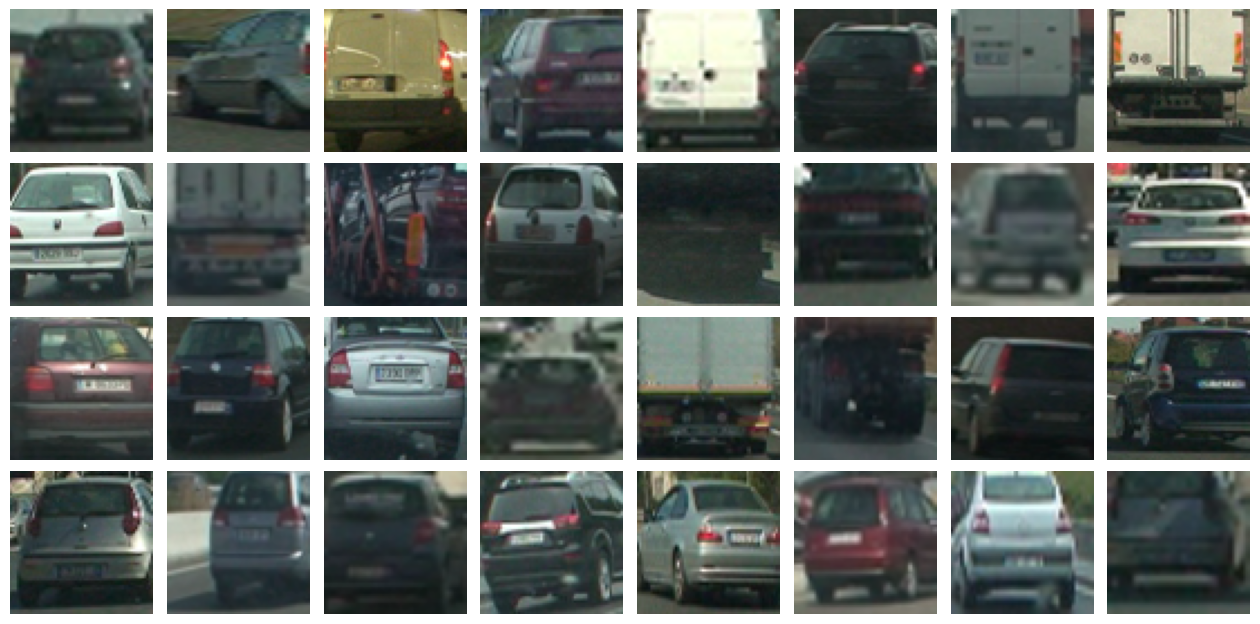

In [ ]:
fig, axs = plt.subplots(4,8, figsize=(16, 8))
fig.subplots_adjust(hspace = 0, wspace=.1)
axs = axs.ravel()

for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0,n_car_images)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)
plt.savefig('output_images/car_samples.png')

### Non-car Image Examples

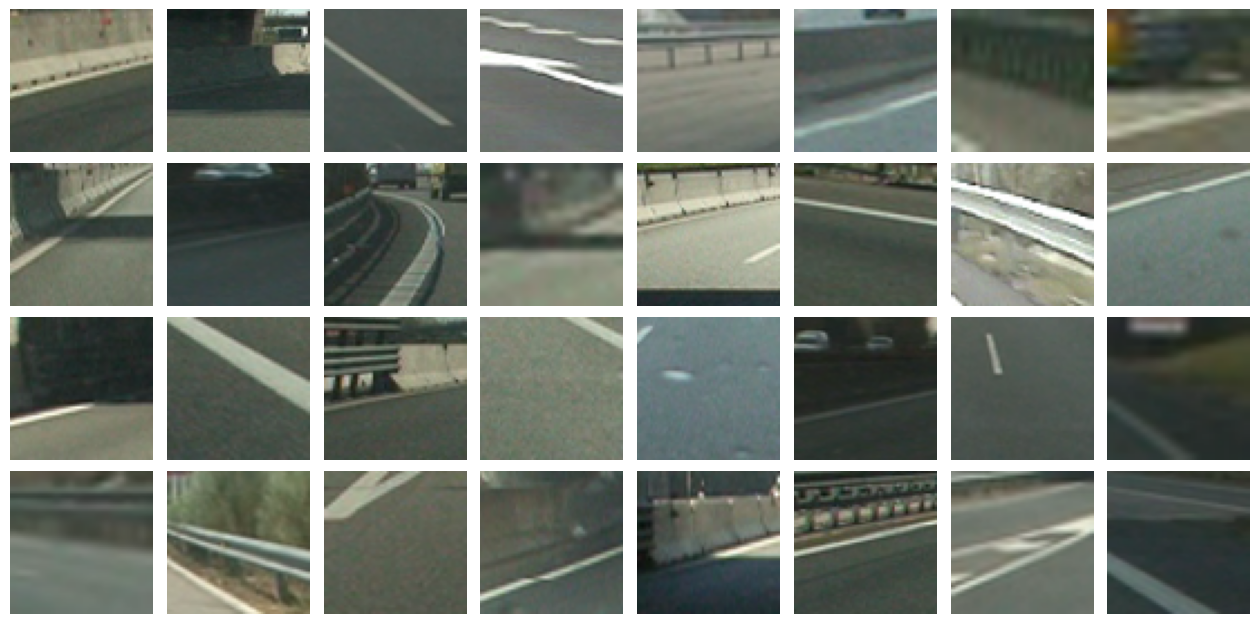

In [ ]:
fig, axs = plt.subplots(4,8, figsize=(16, 8))
fig.subplots_adjust(hspace = 0, wspace=.1)
axs = axs.ravel()

for i in np.arange(32):
    img = cv2.imread(non_car_images[np.random.randint(0,n_non_car_images)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)
plt.savefig('output_images/non_car_samples.png')

## Feature Extraction Method

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
from skimage.feature import hog

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  feature_vector=feature_vec, visualize=True)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       feature_vector=feature_vec, visualize=False)
        return features

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)   

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        
    return features

## HOG Visualisation

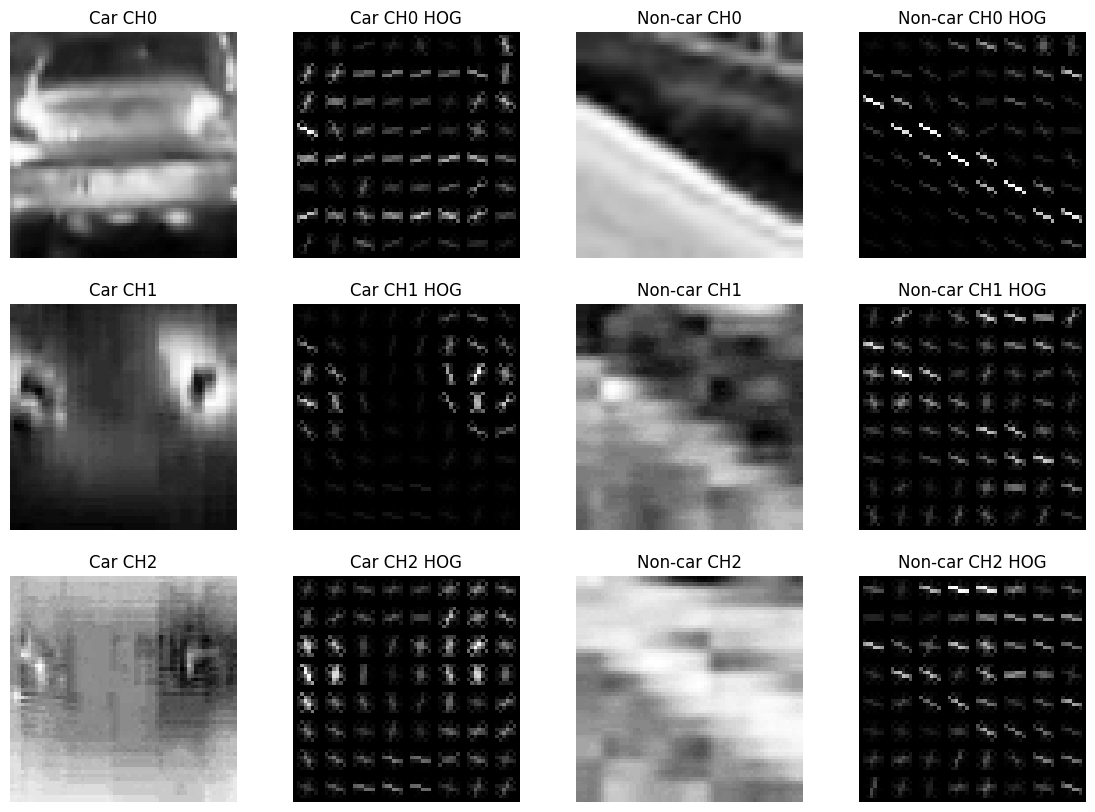

In [ ]:
car_test = mpimg.imread(car_images[35])
car_test = cv2.cvtColor(car_test, cv2.COLOR_RGB2YCrCb)
non_car_test = mpimg.imread(non_car_images[20])
non_car_test = cv2.cvtColor(non_car_test, cv2.COLOR_RGB2YCrCb)

imgs = []
titles = []
for i in range(3):
    for feature_image, img_type in zip([car_test, non_car_test], ['Car', 'Non-car']):
        channel = feature_image[:,:,i]
        imgs.append(channel)
        titles.append(img_type + ' CH%d' % i)
        features, hog_image = get_hog_features(channel, orient=12, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)
        imgs.append(hog_image)
        titles.append(img_type + ' CH%d' % i + ' HOG')
        
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(14, 10))
axes = axes.ravel()
for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(img, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.savefig('output_images/HOG_comparison.png')

## Feature Extraction

In [ ]:
### Parameters
spatial = 32
hist_bins = 32
colorspace = 'YCrCb' 
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size= (32, 32)
heat_threshold= 4 
hog_channel = "ALL" 
ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (500, 710, 2.5)]

car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, hist_range=(0, 256))

non_car_features = extract_features(non_car_images,cspace=colorspace,orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, hist_range=(0, 256))

## Data Preparation

In [ ]:
# Preserve State to compare parameter tuning 
rand_state = np.random.randint(0, 100)


X = np.vstack((car_features, non_car_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 8460


## Classifier

In [ ]:
# Use a linear SVC because HOG gives high dimensional data and linear svm is better with high dimensional data
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Prediction 
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

3.24 Seconds to train SVC...
Test Accuracy of SVC =  0.985
My SVC predicts:      [0. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
For these 10 labels:  [0. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
0.0007 Seconds to predict 10 labels with SVC


## Data Saving to Pickle

In [ ]:
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial"] = spatial
dist_pickle["hist_bins"] = hist_bins
pickle.dump(dist_pickle, open("svc_pickle.p", 'wb') )

print('Classifier parameters saved to file!')

Classifier parameters saved to file!


## Data Loading from Pickle

In [ ]:
print('Loading Classifier parameters...')
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatia = dist_pickle["spatial"]
hist_bins = dist_pickle["hist_bins"]

print('Loading is done!')

Loading Classifier parameters...
Loading is done!


## HOG Sub-sampling Window Search

In [ ]:
def find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, ystart_ystop_scale, h_shift=0, visualisation=False):
    bbox_detection_list = []
    box_vis_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    for (ystart, ystop, scale) in ystart_ystop_scale:
        box_vis = []
        img_tosearch = img[ystart:ystop, :, :]
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (int(imshape[1] / scale), int(imshape[0] / scale)))

        ch1 = ctrans_tosearch[:, :, 0]
        ch2 = ctrans_tosearch[:, :, 1]
        ch3 = ctrans_tosearch[:, :, 2]

        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 3
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
        nfeat_per_block = orient * cell_per_block ** 2

        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb * cells_per_step
                xpos = xb * cells_per_step
                hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos * pix_per_cell
                ytop = ypos * pix_per_cell

                subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int_(xleft * scale)
                    ytop_draw = np.int_(ytop * scale)
                    win_draw = np.int_(window * scale)
                    bbox_detection_list.append(((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                    if visualisation:
                        box_vis.append(((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

        if visualisation:
            box_vis_list.append(box_vis)

    return bbox_detection_list, bbox_detection_list, box_vis_list

## Region Proposer Visualisation

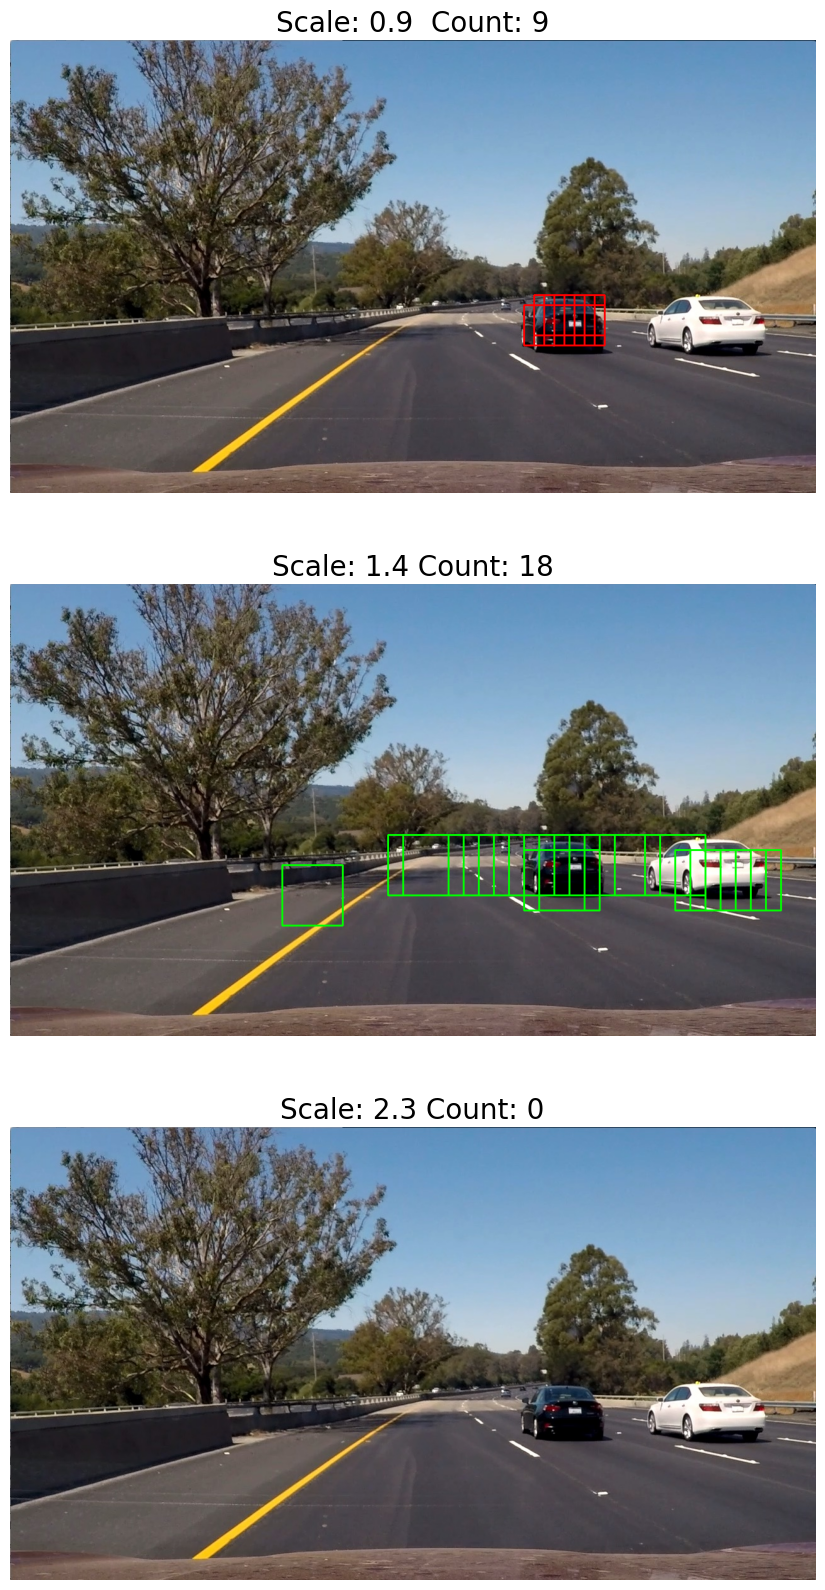

In [ ]:
test_image_sliding = test_images[0]
ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (415, 710, 2.5)]
bbox_detection_list, detections, box_vis_list = find_cars(test_image_sliding, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, ystart_ystop_scale, h_shift=500, visualisation=True)

def draw_boxes(img, bboxes, thickness=2):
    imcopy = [np.copy(img), np.copy(img), np.copy(img)]
    color = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    for i in range(len(bboxes)):
        for bbox in bboxes[i]:
            cv2.rectangle(img=imcopy[i], pt1=bbox[0], pt2=bbox[1], color=color[i], thickness=thickness)
    return imcopy

windows_img = draw_boxes(test_image_sliding, box_vis_list)

f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(20, 20))
ax1.imshow(windows_img[0])
title = "Scale: 0.9 " + " Count: " + str(len(box_vis_list[0]))
ax1.set_title(title, fontsize=20)
ax1.axis("off")
ax2.imshow(windows_img[1])
title = "Scale: 1.4" + " Count: " + str(len(box_vis_list[1]))
ax2.set_title(title, fontsize=20)
ax2.axis("off")
ax3.imshow(windows_img[2])
title = "Scale: 2.3" + " Count: " + str(len(box_vis_list[2]))
ax3.set_title(title, fontsize=20)
ax3.axis("off")

plt.savefig('output_images/bbox_vis.png')

## Overall Pipeline

### Heatmapping

In [ ]:
class Detect_history():
    def __init__ (self):
        self.queue_len = 7 
        self.queue = []

    def put_labels(self, labels):
        if (len(self.queue) > self.queue_len):
            tmp = self.queue.pop(0)
        self.queue.append(labels)
    
    def get_labels(self):
        detections = []
        for label in self.queue:
            detections.extend(label)
        return detections

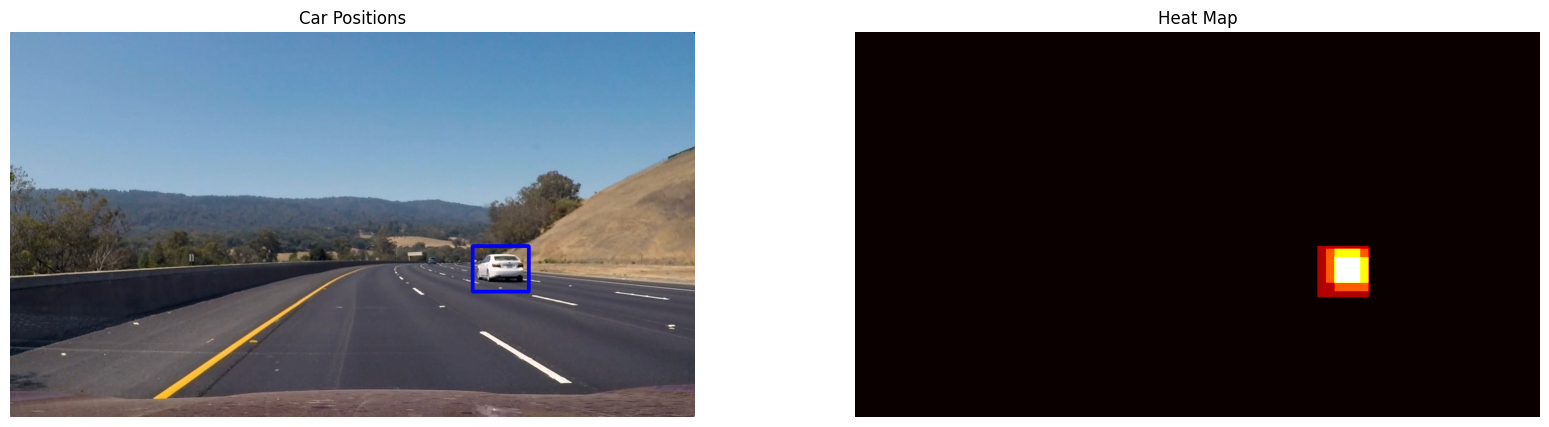

In [ ]:
image = test_images[3]
blank = np.zeros_like(image[:,:,0]).astype(np.float64)

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], (bbox[1][0]+10,bbox[1][1]-10), (0,0,255), 6)
    return img


bbox_detection_list, detections, box_vis_list = find_cars(image, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,ystart_ystop_scale)

heatmap = add_heat(blank, bbox_detection_list)

labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize = (20,5))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.axis('off')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.axis('off')

plt.savefig('output_images/heatmap.png')

In [ ]:
### Parameters
spatial = 32
hist_bins = 32
colorspace = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size= (32, 32)
heat_threshold= 4 
hog_channel = "ALL" 
ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (500, 710, 2.5)]

def process_image(img): 
    
    bbox_detection_list, detections, box_vis_list = find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,ystart_ystop_scale)

    blank = np.zeros_like(img[:,:,0]).astype(np.float64)

    detect_history.put_labels(bbox_detection_list)
    bbox_detection_list = detect_history.get_labels()

    heatmap = add_heat(blank, bbox_detection_list)
    labels = label(heatmap)
    result = draw_labeled_bboxes(np.copy(img), labels)
    
    return result

(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

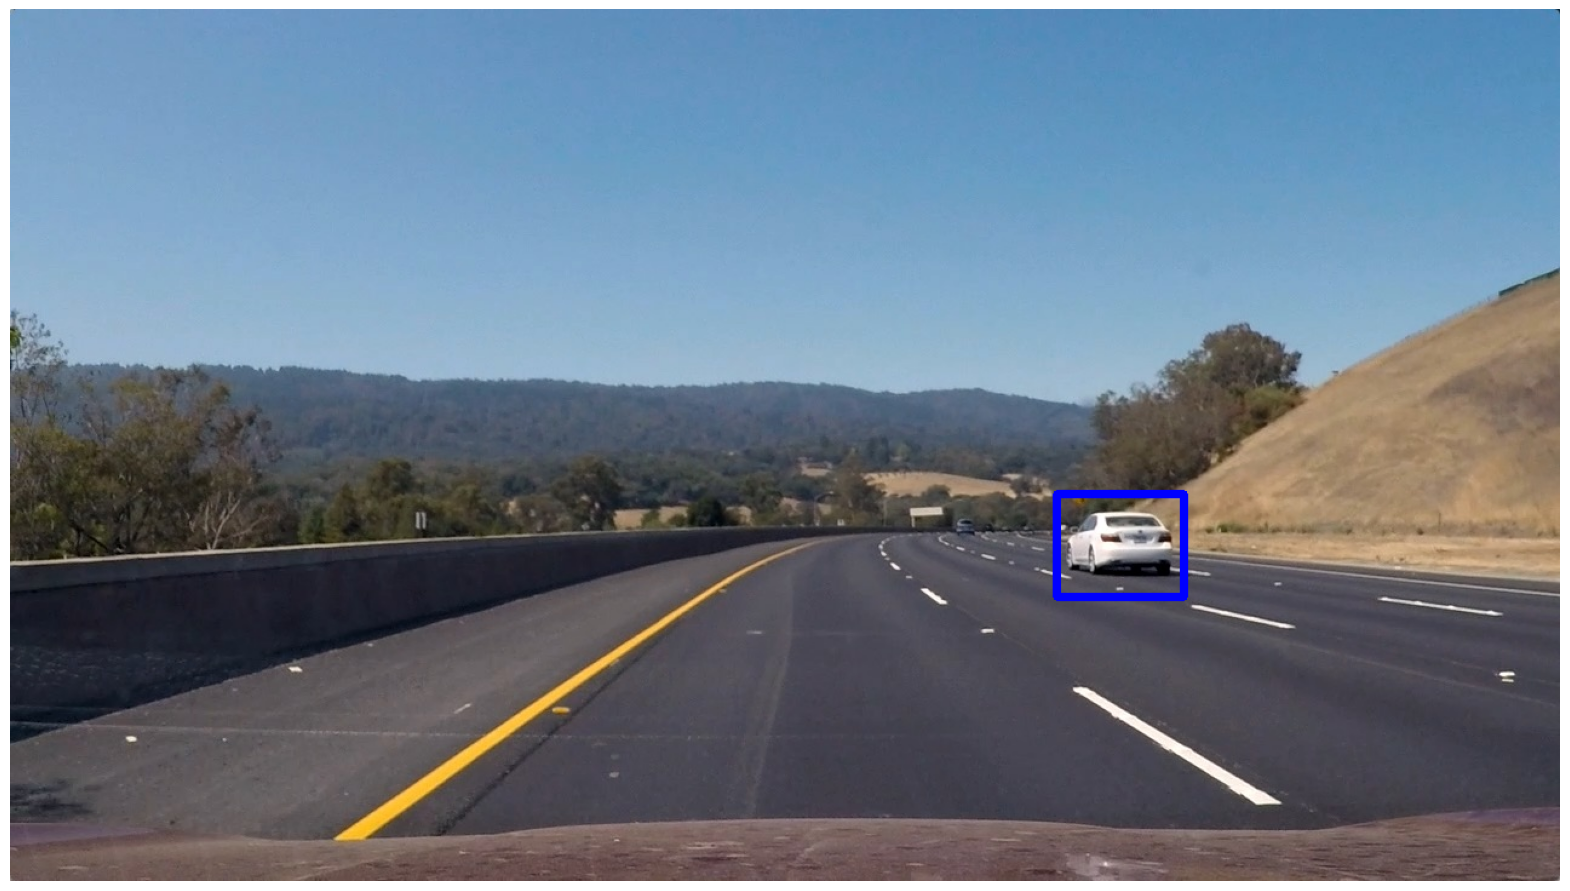

In [ ]:
detect_history = Detect_history()

result = process_image(test_images[3])
plt.figure(figsize = (20,20))
plt.imshow(result)
plt.axis("off")

## Process Video

In [ ]:
detect_history = Detect_history()
project_video_res = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image)
project_video_clip.write_videofile(project_video_res, audio=False)

Moviepy - Building video project_video_result.mp4.
Moviepy - Writing video project_video_result.mp4



Moviepy - Done !
Moviepy - video ready project_video_result.mp4
